In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import os
import seaborn as sns


# IB_CF

In [10]:
rating_data = pd.read_csv("/home/ubuntu/Bigdata_Analytics/Haeun Koo/practice/ratings.csv")
movie_data = pd.read_csv('/home/ubuntu/Bigdata_Analytics/Haeun Koo/practice/movies.csv')

In [30]:
movie_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
rating_data = rating_data.drop('timestamp', axis = 1)

In [13]:
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')

In [15]:
movie_user_data = user_movie_data.pivot_table('rating', index = 'title', columns = 'userId')
user_movie_data = user_movie_data.pivot_table('rating', index = 'userId', columns = 'title')

In [19]:
movie_user_data = movie_user_data.fillna(0)

In [20]:
ib_cf = cosine_similarity(movie_user_data)

In [24]:
ib_cf = pd.DataFrame(data = ib_cf, index = movie_user_data.index, columns = movie_user_data.index)

In [27]:
def get_ib_cf(title):
    return ib_cf[title].sort_values(ascending = False)[:10]

In [31]:
get_ib_cf('Toy Story (1995)')

title
Toy Story (1995)                                     1.000000
Toy Story 2 (1999)                                   0.572601
Jurassic Park (1993)                                 0.565637
Independence Day (a.k.a. ID4) (1996)                 0.564262
Star Wars: Episode IV - A New Hope (1977)            0.557388
Forrest Gump (1994)                                  0.547096
Lion King, The (1994)                                0.541145
Star Wars: Episode VI - Return of the Jedi (1983)    0.541089
Mission: Impossible (1996)                           0.538913
Groundhog Day (1993)                                 0.534169
Name: Toy Story (1995), dtype: float64

# Matrix factorization

In [32]:
movie_data = movie_data.drop('genres', axis = 1)

In [39]:
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')

In [40]:
user_movie_data = user_movie_data.pivot_table('rating', index = 'userId', columns = 'title')

In [41]:
user_movie_data = user_movie_data.fillna(0)

In [42]:
user_movie_data

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [43]:
movie_user_rating = user_movie_data.values.T

In [46]:
user_movie_data.shape

(610, 9719)

In [53]:
SVD = TruncatedSVD(n_components = 12)

In [55]:
matrix = SVD.fit_transform(movie_user_rating)
matrix[0]

array([ 0.55545971,  0.80876909, -0.37068841, -0.06637271,  0.63147569,
       -1.00743188, -0.25800786, -0.83764996, -0.79682223,  0.30901206,
       -0.5700497 ,  0.61691605])

<AxesSubplot:>

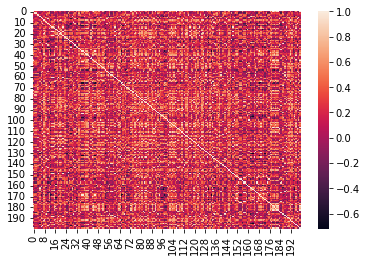

In [61]:
corr = np.corrcoef(matrix)
corr_ = corr[:200, :200]
sns.heatmap(corr_)

In [63]:
movie_title = user_movie_data.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Toy Story (1995)")

In [64]:
corr_coffey_hands = corr[coffey_hands]

In [65]:
list(movie_title[(corr_coffey_hands >= 0.9)])[:50]

['Aladdin (1992)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Batman (1989)',
 'Beauty and the Beast (1991)',
 'Forrest Gump (1994)',
 'Ghost (1990)',
 'Home Alone (1990)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Jumanji (1995)',
 'Jurassic Park (1993)',
 'Lion King, The (1994)',
 'Mask, The (1994)',
 'Mission: Impossible (1996)',
 'Mrs. Doubtfire (1993)',
 'Pretty Woman (1990)',
 'Toy Story (1995)',
 'Willy Wonka & the Chocolate Factory (1971)']

# personalization MF

In [67]:
user_movie_ratings = rating_data.pivot(
index = 'userId',
columns = 'movieId',
values = 'rating'
).fillna(0)

In [70]:
matrix = user_movie_ratings.to_numpy()

In [72]:
user_ratings_mean = np.mean(matrix, axis = 1)

In [74]:
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [76]:
U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [79]:
sigma = np.diag(sigma)

In [81]:
sigma[0]

array([107.04782929,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [82]:
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [87]:
svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = user_movie_ratings.columns)

In [88]:
svd_preds

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,3.025742,1.064889,1.128442,-0.007380,0.269200,1.352572,0.197042,0.040178,0.202469,1.849843,...,-0.002547,-0.002072,-0.003022,-0.003022,-0.002547,-0.003022,-0.002547,-0.002547,-0.002547,-0.018183
1,0.197681,0.004294,0.019201,0.006291,0.055386,-0.023002,-0.040784,0.006082,0.004302,-0.085805,...,0.012057,0.010906,0.013208,0.013208,0.012057,0.013208,0.012057,0.012057,0.012057,0.017887
2,0.061963,0.018020,0.025739,0.005934,-0.018317,0.062320,-0.012573,0.014263,0.018741,0.044514,...,0.010269,0.010216,0.010322,0.010322,0.010269,0.010322,0.010269,0.010269,0.010269,0.008081
3,1.612323,0.258021,0.230965,0.048206,0.141789,0.382312,0.326798,-0.028809,-0.042584,0.041267,...,-0.016587,-0.016129,-0.017045,-0.017045,-0.016587,-0.017045,-0.016587,-0.016587,-0.016587,-0.024347
4,1.294989,0.985834,0.406003,0.124765,0.519566,0.791518,0.627357,0.127782,0.108770,1.139558,...,-0.003245,-0.003251,-0.003240,-0.003240,-0.003245,-0.003240,-0.003245,-0.003245,-0.003245,-0.003586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,1.155949,0.515691,-1.423468,0.103737,-0.013533,1.213081,1.744070,-0.579607,-0.240034,0.576091,...,0.041070,0.041511,0.040629,0.040629,0.041070,0.040629,0.041070,0.041070,0.041070,0.011236
606,2.650707,0.976896,0.617954,0.048217,0.228272,1.794521,0.309010,0.088775,0.168180,1.807866,...,0.009899,0.011129,0.008669,0.008669,0.009899,0.008669,0.009899,0.009899,0.009899,0.002677
607,2.585871,1.798290,1.679005,-0.112338,0.434616,3.510546,0.490877,0.275927,0.196052,4.120091,...,-0.069384,-0.061228,-0.077540,-0.077540,-0.069384,-0.077540,-0.069384,-0.069384,-0.069384,-0.017863
608,0.823037,0.648461,0.314831,0.088076,0.356754,0.672984,0.404396,0.088087,0.105450,0.949886,...,0.006841,0.006792,0.006889,0.006889,0.006841,0.006889,0.006841,0.006841,0.006841,0.007509


In [100]:
def recommend_movie(svd_preds, user_id, ori_movies_df, ori_ratings_df, num_recommendation = 5):
    
    user_row_number = user_id - 1
    
    sorted_user_predictions = svd_preds.iloc[user_row_number].sort_values(ascending = False)
    
    user_data = ori_ratings_df[ori_ratings_df.userId == user_id]
    
    user_history = user_data.merge(ori_movies_df, on = 'movieId').sort_values(['rating'], ascending = False)
    
    recommendations = ori_movies_df[~ori_movies_df['movieId'].isin(user_history['movieId'])]
    
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendation, :]
    
    return user_history, recommendations

In [101]:
seen_rating, predictions = recommend_movie(svd_preds, 330, movie_data, rating_data, 10)

In [104]:
predictions

,movieId,title,Predictions
408,527,Schindler's List (1993),4.255811
1146,1704,Good Will Hunting (1997),3.033801
3405,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",2.852480
707,1036,Die Hard (1988),2.675696
817,1221,"Godfather: Part II, The (1974)",2.613103
1423,2115,Indiana Jones and the Temple of Doom (1984),2.473030
4194,6539,Pirates of the Caribbean: The Curse of the Bla...,2.460223
227,293,Léon: The Professional (a.k.a. The Professiona...,2.441789
3422,4995,"Beautiful Mind, A (2001)",2.391334
2803,4027,"O Brother, Where Art Thou? (2000)",2.178089
